### isolates: genome annotation and variant calling

* prokka: https://github.com/tseemann/prokka

In [18]:
import sys,os,subprocess,glob,shutil
%matplotlib inline
import pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from importlib import reload

plt.rcParams["figure.dpi"] = 150
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Phylo, AlignIO
from tools import *
#from epitopepredict import sequtils
Entrez.email = 'A.N.Other@example.com'
from matplotlib.colors import ListedColormap, LogNorm
import matplotlib.patches as mpatches
from IPython.display import display, HTML
pd.set_option('display.width', 130)
pd.set_option('display.max_colwidth', 120)
pd.set_option("max_r",120)
clrs = ["#007acc", "#2ecc71", "#e74c3c"]
my_cmap = ListedColormap(sns.color_palette(clrs).as_hex())
sns.set_style("white", {'font_scale':1.1})

In [16]:
info = pd.read_csv('isolates.csv')
names = info.id
isolates = info[info.stage!='reference'].id
acinet = ['RF14B','RF15A','RF15B']#,'909D3A']
refs = ['ecoli_k12','ecoli_IAI39','ecoli_O104_str.2011C-3493','ecoli_UMN026','ecoli_O157_str.Sakai']
acinrefs=['Acin_lwof_NCTC5866','Acin_lwof_ZS207','Acin_baum_ASM74664']
ecoli = ['RF1A', 'RF2A', 'RF2B', 'RF2C', 'RF5A', 'RF6A1', 'RF6A2', 'RF6B', 'RF6C', 'RF7A', 
         'RF8A', 'RF8B', 'RF9', 'RF11', 'RF12A', 'RF14A', 'RF16A']
pen = ['RF14B', 'RF15A', 'RF15B', 'RF14A','RF16A', 'ecoli_k12', 'Acin_lwof_NCTC5866']
pig = ecoli[:-8] + ['ecoli_k12'] + acinet + ['Acin_lwof_NCTC5866']
dog=['9805','9808']
print (ecoli)

['RF1A', 'RF2A', 'RF2B', 'RF2C', 'RF5A', 'RF6A1', 'RF6A2', 'RF6B', 'RF6C', 'RF7A', 'RF8A', 'RF8B', 'RF9', 'RF11', 'RF12A', 'RF14A', 'RF16A']


In [4]:
stage = info[:20].set_index('id').stage
pal =sns.color_palette('hls', len(stage.unique()))
lut = dict(zip(stage.unique(), pal))
print lut
row_colors = stage.map(lut)

{'farrowing': (0.86, 0.3712, 0.33999999999999997), 'hospital pen': (0.6311999999999998, 0.33999999999999997, 0.86), '1st stage weaner': (0.5688000000000001, 0.86, 0.33999999999999997), '2nd stage weaner': (0.33999999999999997, 0.8287999999999999, 0.86)}


In [ ]:
d=[]
for name in info.id:
    files = glob.glob( 'data/'+name+'*.gz')    
    x = [os.path.basename(f) for f in files]
    if len(x)>1:
        d.append([name, x[0],x[1]])
#pd.DataFrame(d)

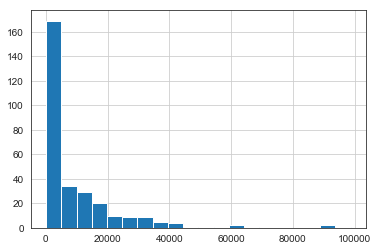

In [22]:
f='data/RF14B_S3_L001_R1_001.fastq.gz'
#df=fastq_to_dataframe(f)
df=fasta_to_dataframe('scaffolds/RF14B.fa')
df.sequence.str.len().hist(bins=20)
#df.sequence.str.len().sort_values()

## trim adapters

In [7]:
#gnl|uv|NGB00757.1:1-65 Illumina TruSeq DNA 
adapter1='TCCAGTCACCGCTCATTATCTCGTATGCCGTCTTCTGCTTG'
def trim(name1,name2):    
    out1='trimmed/%s' %name1
    out2='trimmed/%s' %name2
    #cmd='cutadapt --cores=8 -a {a} -o {o} data/{i}'.format(o=out,i=name,a=adapter1)
    cmd='cutadapt --cores=8 -a {a} -A {a} -o {o1} -p {o2} data/{i1} data/{i2}'.format(o1=out1,o2=out2,i1=name1,i2=name2,a=adapter1)

    print(cmd)
    #subprocess.check_output(cmd, shell=True)
    
trim('RF14B_S3_L001_R1_001.fastq.gz','RF14B_S3_L001_R2_001.fastq.gz')

cutadapt --cores=8 -a TCCAGTCACCGCTCATTATCTCGTATGCCGTCTTCTGCTTG -A TCCAGTCACCGCTCATTATCTCGTATGCCGTCTTCTGCTTG -o trimmed/RF14B_S3_L001_R1_001.fastq.gz -p trimmed/RF14B_S3_L001_R2_001.fastq.gz data/RF14B_S3_L001_R1_001.fastq.gz data/RF14B_S3_L001_R2_001.fastq.gz


### spades assembly

In [12]:
def spades(name):
    path = 'assembly' 
    path = 'assembly_trimmed' 
    files = sorted(glob.glob( 'trimmed/'+name+'*.gz'))
    out = '%s/%s' %(path,name)
    cmd = '/local/SPAdes-3.13.0-Linux/bin/spades.py --pe1-1 %s --pe1-2 %s --careful -o %s' %(files[0],files[1],out)
    print (cmd)
    #if not os.path.exists(out): 
    #    subprocess.check_output(cmd, shell=True)
    return

spades('RF14B')
#for n in ecoli:
    #spades(n)
    #pth='assembly/%s' %n
    #print pth
    #shutil.copy(os.path.join(pth,'scaffolds.fasta'), 'scaffolds/%s.fa' %n)  
    #shutil.copy(os.path.join(pth,'contigs.fasta'), 'contigs/%s.fa' %n)  

/local/SPAdes-3.13.0-Linux/bin/spades.py --pe1-1 trimmed/RF14B_S3_L001_R1_001.fastq.gz --pe1-2 trimmed/RF14B_S3_L001_R2_001.fastq.gz --careful -o assembly_trimmed/RF14B


In [14]:
#quast
s=' '.join(['scaffolds/%s.fa' %i for i in ecoli+dog])
#print s
cmd = 'quast.py %s -R genomes/ecoli_k12.fa -o quast_results -t 4' %s
print (cmd)

quast.py scaffolds/RF1A.fa scaffolds/RF2A.fa scaffolds/RF2B.fa scaffolds/RF2C.fa scaffolds/RF5A.fa scaffolds/RF6A1.fa scaffolds/RF6A2.fa scaffolds/RF6B.fa scaffolds/RF6C.fa scaffolds/RF7A.fa scaffolds/RF8A.fa scaffolds/RF8B.fa scaffolds/RF9.fa scaffolds/RF11.fa scaffolds/RF12A.fa scaffolds/RF14A.fa scaffolds/RF16A.fa scaffolds/9805.fa scaffolds/9808.fa -R genomes/ecoli_k12.fa -o quast_results -t 4


### contig stats

In [ ]:
df=pd.read_csv('quast_results/report.tsv',sep='\t')
df=df.set_index('Assembly').T
print df.columns
df['# contigs (>= 0 bp)'][2:].astype('int').median()
df['Total length'].astype('int').min()
#df['N50']  
#df

### prokka annotation of contigs

In [ ]:
out='annot_scaff'
path = 'contigs'
path = 'scaffolds'
path = 'genomes'

a = glob.glob('genomes/Acin*.fa')
a = [os.path.basename(i) for i in a]
#print a

r = ['Acin_schi_str_ACE','Acin_sp_ACNIH1','Acin_sp_LoGeW2-3']
for n in r :
    cmd = 'prokka --outdir {o}/{n} {p}/{n}.fa --prefix {n} \
    --hmms Resfams.hmm'.format(n=n,o=out,p=path)
    #print cmd
    if not os.path.exists('%s/%s' %(out,n)):
        print cmd
        subprocess.check_output(cmd, shell=True) 
  

### annotation comparison, ecoli

In [5]:
def log_heatmap(x,ax=None):    
    if ax==None:
        w=len(x)/5+2
        plt.figure(figsize=(w,8))
    sns.heatmap(x,lw=0,yticklabels=1,#annot=True,norm=LogNorm(vmin=x.min(), vmax=x.max())
                annot_kws={'fontsize':9},cbar=False,cmap=my_cmap)
    #x=x.fillna(0)    
    return

def color_cell(val):
    color = 'blue' if val ==1 else None
    return 'background-color: %s' % color

res=prokka_results('annot_scaff', ecoli+['ecoli_k12']) #pen
res.to_csv('prokka_results.csv')

#plot_products(res)


RF1A 2453
RF2A 4062
RF2B 4522
RF2C 4896
RF5A 4404
RF6A1 4554
RF6A2 5626
RF6B 4423
RF6C 3208
RF7A 4679
RF8A 4974
RF8B 4981
RF9 4712
RF11 4762
RF12A 5605
RF14A 4937
RF16A 5582
ecoli_k12 4406


In [ ]:
roary = pd.read_csv('roary_ecoli/gene_presence_absence.csv')
x = get_presence_absence(roary)
x.index=x.index.droplevel([0,2])
print x.columns
x=x.drop(refs[1:],1)

#core genes in x genomes
x['group'] = np.where(x.sum(1)/x.count(1)>.7,'core','accessory')
x.groupby(['group']).sum().T.plot(kind='bar', stacked=True, figsize=(10,4))
plt.title('Annotated Proteins',fontsize=20)
plt.ylabel('proteins')
plt.tight_layout()
plt.savefig('roary_counts_ecoli.png')

In [ ]:
ani=pd.read_csv('ANIm.csv')
ani = ani.set_index('name')
sns.heatmap(ani,cmap='coolwarm')#,annot_kws={'format':'%1.2f'})

### heatmap for paper figure

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



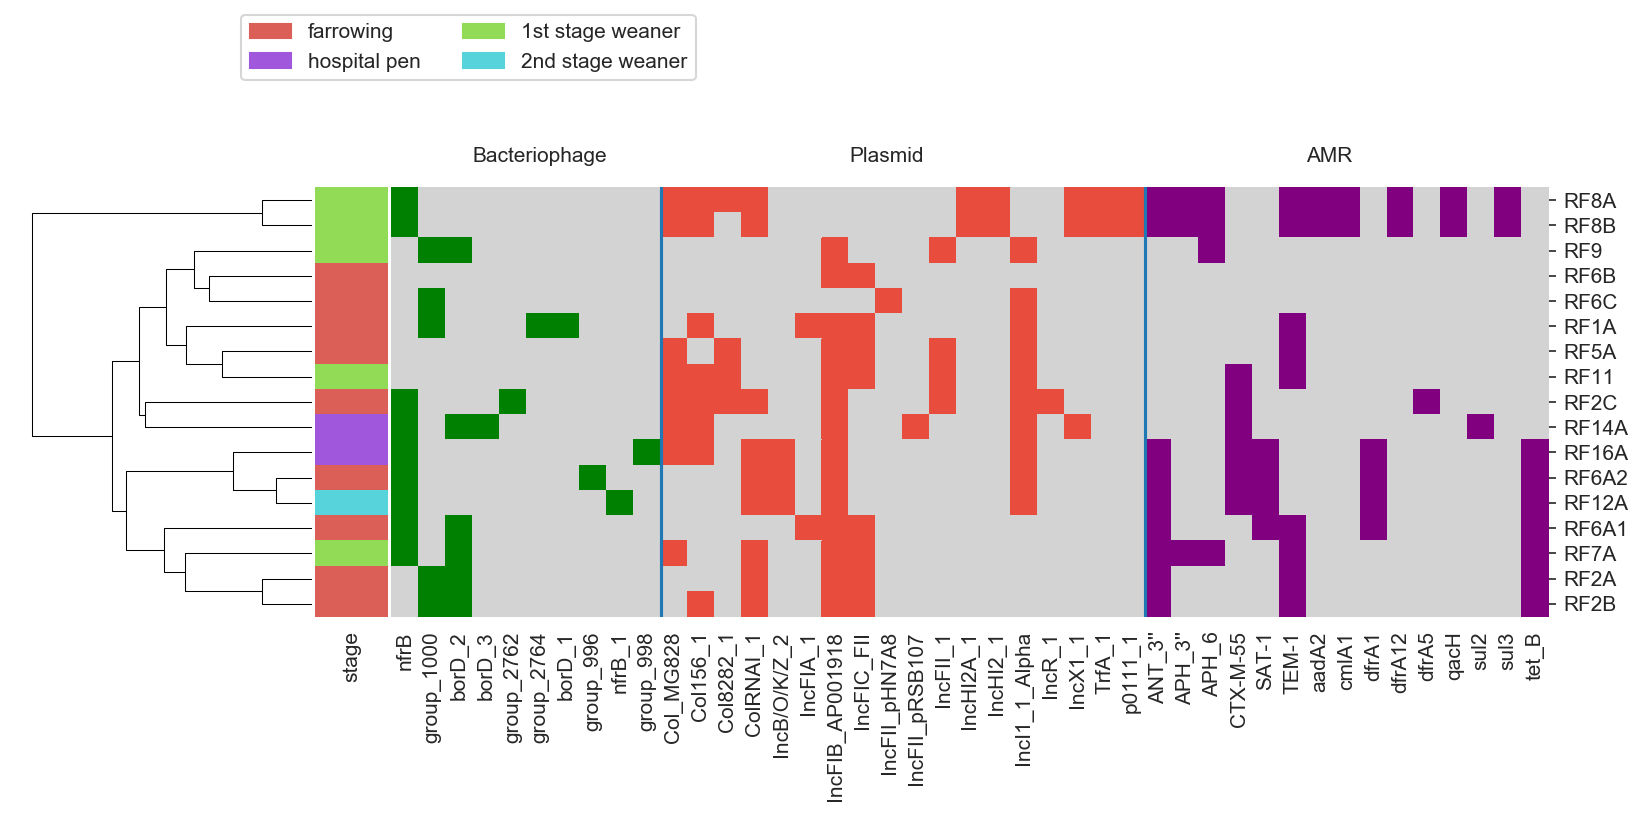

In [14]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x

#plot for paper
p=[]
i=0
for f in ['roary_counts_bacteriophage.csv','abr_plasmidfinder_counts.csv','abr_card_counts.csv']:
    df= pd.read_csv(f,index_col=0).T
    #print df
    df= df.clip_upper(1)
    df = df+i    
    i+=1
    p.append(df)  
p = pd.concat(p)

clrs = ["lightgray", "green", "#e74c3c", "purple"]
my_cmap = ListedColormap(sns.color_palette(clrs).as_hex())

p=p[ecoli].fillna(0).T 

#p=merge_info(p)
empty = p.columns[(p==0).all(0)]
p = p.drop(empty,1)
#print p.columns
p.columns = p.columns.map(lambda x: x.split(')')[0].replace('(','_'))
#print p
#sns.set(font_scale=1.2)
cg=sns.clustermap(p, cmap=my_cmap, col_cluster=False, row_colors=row_colors,xticklabels=1,yticklabels=1, figsize=(12,6))
fig=cg.fig
ax=cg.ax_heatmap
cg.cax.set_visible(False)
leg = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
cg.ax_heatmap.legend(handles=leg,loc='upper center', bbox_to_anchor=(0.3, .98), ncol=2,
                     bbox_transform=plt.gcf().transFigure,frameon=True)

ax.text(3,-1,'Bacteriophage')
ax.text(17,-1,'Plasmid')
ax.text(34,-1,'AMR')
ax.axvline(10)
ax.axvline(28)
#plt.tight_layout()
fig.subplots_adjust(top=.88,left=.05,bottom=.3)
fig.savefig('pig_gene_heatmap.png',dpi=150)

### roary results

In [ ]:
import shutil
fl=glob.glob('annot_scaff/*')
for f in ecoli: 
    #print f
    fn=glob.glob('annot_scaff/%s/*.gff' %f)[0]
    print fn
    shutil.copy(fn,'gff_scaff')

In [ ]:
cmd = 'roary -f roary_ecoli -e -n -v -z -i 85 -cd 70 -p 8 gff_scaff/*.gff'
roary = pd.read_csv('roary_ecoli/gene_presence_absence.csv')

#print roary.cat.value_counts()
x = get_presence_absence(roary)#,cols=['9805','9808','ecoli_k12'])

summ = x.reset_index().groupby('cat').sum()
#print summ[ecoli].median(1)
#print summ['ecoli_k12']

genes_clustermap(x.T)

filt = x[(x[ecoli].sum(1)>=6) & (x[refs].sum(1)==0)].reset_index()
#print filt
c = filt.cat.value_counts()
print c[:10]
#c[1:10].plot(kind='pie',figsize=(6,6))

In [ ]:
mycats = ['ARO','prophage','bacteriophage','phage','integrase']
#df=x.reset_index()
#df=df[df.cat.isin(mycats)]
#df.style.applymap(color_red).to_excel('roary_genes_all.xlsx', engine='openpyxl')
#print df[:3]

for n in mycats[:3]:
    df = x.loc[(n)]
    print n, len(df)
    df=df[df.ecoli_k12==0]
    #print df
    #print df.sum(1).sort_values(ascending=False)
    df.index = df.index.droplevel(1)    
    #df = df[ecoli]    
    df.T.to_csv('roary_counts_%s.csv' %n)
    #print df.reset_index().Annotation.value_counts()
    genes_clustermap(df.T, title=n)#,fname='roary_genes_cluster_%s.png' %n)
    plt.savefig('roary_counts_%s.png' %n)
        
x.to_csv('genes_not_k12.csv',index=False)

### contig report

In [ ]:
files = ['gff_scaff/%s.gff' % n for n in ecoli]
contig_report(files, 'contig_report.html', key='ARO')

### features on contigs with abr genes

In [ ]:
abr = pd.read_csv('abr_all.csv')
abr = abr[abr.DATABASE.isin(['card','vfdb'])]

def get_features(gff_file, ids, plot=True):
    """read gff from prokka to get proteins in each contig"""
    from BCBio import GFF
    handle = open(gff_file)
    data={}
    for rec in list(GFF.parse(handle)):
        if rec.id in ids:      
            print rec.id
            x = []
            for feat in rec.features:
                q=feat.qualifiers
                del q['source']                
                if 'gene' not in q:
                    try:
                        q['gene'] = q['locus_tag']
                    except:
                        continue
                q['locus_tag'] = q['product'][0][:20]
                f = (str(feat.location), q['product'][0], q['gene'][0])
                print f
                x.append(f)
            print
            data[rec.id] = x            
            if plot==True:
                graphic_record = BiopythonTranslator().translate_record(rec)
                ax, _ = graphic_record.plot(figure_width=20)
                plt.title(rec.id)
                plt.show()           
    handle.close()
    return data

for name in ecoli:
    original = sys.stdout
    sys.stdout = open('contig_features/%s.txt' %name,'w')
    x=abr[abr.id==name]
    #print x
    found = x.SEQUENCE
    print name    
    print '%s genes found by abricate in this isolate' %len(x.GENE.unique())
    print '%s contigs' %len(found.unique())
    print
    gff_file = 'gff_scaff/{n}.gff'.format(n=name) 
    for f in found.unique():        
        feats = get_features(gff_file, f, plot=False)
    print '-------------------------------------------'
    #print feats
    sys.stdout = original

### spine results

In [ ]:
cmd='perl Spine/spine.pl -f contig_list_ecoli.txt -t 6 -o results -r 1 -a 80'
#spine results
sp=pd.read_csv('spine_results/results.statistics.txt',skiprows=3,sep='\t',comment='#')
from IPython.core.display import display
display(sp[:4])
sp = sp[sp.gen_name.isin(ecoli)]

sns.set_context("notebook", font_scale=1.1)
f=sns.factorplot(x='gen_name',y='total_bp',data=sp,kind='bar',aspect=4,size=3.5,row='source',sharey=False)
plt.savefig('spine_bp_stats.png')
f=sns.factorplot(x='gen_name',y='gc_%',data=sp,hue='source',kind='bar',aspect=4)


In [ ]:
names = ['rpoB']

#seqs,lbls = get_roary_protein(ecoli, 'borD_1', roary)
seqs=[]
for g in ['borD','borD_1','borD_2']:
    s,l=get_roary_protein(g, 'roary_ecoli')#, samples=['RF14A'])
    #seqs.extend(s)
    for i in s:
        print g,i.seq
        
a = get_roary_gene('coaD','roary_ecoli')

### trees from core alignment and binary acc. genes

In [ ]:
seqs = AlignIO.read('roary_ecoli/core_gene_alignment.aln','fasta')
seqs = [s for s in seqs if s.id not in ['9808','9805','RF1A','RF6C','ecoli_O157_str.Sakai','ecoli_IAI39']]
#aln=AlignIO.MultipleSeqAlignment(seqs)
#dm,tree=get_tree(aln)
#aln2 = AlignIO.read('roary_ecoli/accessory_binary_genes.fa','fasta')
#dm2,tree2=get_tree(aln2)
#Phylo.write([tree,tree2], 'roary_ecoli_trees.xml', 'phyloxml')

labels = info.set_index('id')['stage'].to_dict()
mlst = pd.read_csv('results_MLST.csv')
mlstlabels = mlst.set_index('name')['ST'].fillna('').to_dict()

r=Phylo.parse('roary_ecoli_trees.xml', 'phyloxml')
tree=r.next()
f,tr=draw_tree(tree,title='core genes',labels=l,root='ecoli_O104_str.2011C-3493')
f.savefig('tree_ecoli_core.png')
#tree2=r.next()
#f,tr=draw_tree(tree2,root='ecoli_k12',title='accessory genes',labels=l)
#f.savefig('tree_ecoli_accessory_binary.png')

### ete tree

In [ ]:
def ete_draw(t,fname=None,title='',outfile='ete_tree.png'):
    from ete3 import Tree, TreeStyle, Phyloxml, TextFace
    t.children
    ts = TreeStyle()
    #ts.branch_vertical_margin = 10
    ts.scale =  800
    ts.show_leaf_name = False    
    #ts.mode = "c"   
    ts.title.add_face(TextFace(title, fsize=20), column=0)        
    def render():    
        display(t.render("%%inline",tree_style=ts,w=500) )
    render()
    t.render(outfile,dpi=300,h=800,tree_style=ts)
    return

def ete_colors(tree, colors=None):
    for node in tree.traverse():  
        if node.name in colors:
            #lbl = labels[node.name]
            clr = colors[node.name]            
            node.add_face(TextFace(node.name, fsize=14), column=0, position='branch-right')
            #f2=TextFace(lbl)
            #node.add_face(f2, column=1, position='aligned')
            #f2.margin_left = 10
            nstyle = NodeStyle()
            nstyle["fgcolor"] = clr
            nstyle["size"] = 15
            node.set_style(nstyle)

def ete_labels(tree, labels, column=1):
    for node in tree.traverse():  
        if node.name in labels:
            lbl = labels[node.name]                        
            f2=TextFace(lbl)
            node.add_face(f2, column=column, position='aligned')
            f2.margin_left = 10
            
def get_ete_tree(filename,index=0):    
    from ete3 import Tree, Phyloxml
    p = Phyloxml()
    p.build_from_file(filename)   
    t = p.get_phylogeny()[index]
    return t

t=get_ete_tree('roary_ecoli_trees.xml',1)
#print t
labels = info.set_index('id')['stage'].to_dict()
stage_colors={'farrowing': 'red', 
              'hospital pen': 'purple',
              '1st stage weaner': 'lightgreen',
              '2nd stage weaner': 'cyan',
              'reference':'black' }
colors={}
for i in labels: 
    if labels[i] in stage_colors:
        colors[i] = stage_colors[labels[i]]

ete_colors(t, colors)
ete_labels(t, labels)
ete_labels(t, mlstlabels, 2)
ete_draw(t,outfile='tree_ecoli_core.png')


### use selected housekeeping genes from roary to make an alignment and ML tree

In [ ]:
from Bio.Phylo.Consensus import *
from Bio.Phylo.Applications import PhymlCommandline

def get_concatenated_genes(genes, path='roary', omit=[]):
    """get subsets of genes from roary and concatenate"""
    seqrecs={}
    for g in genes:       
        aln = get_roary_gene(g, path)        
        if aln is None:
            continue        
        for seq in aln:
            n = seq.id
            if n not in seqrecs:
                seqrecs[n] = ''
            seqrecs[n]+=seq.seq
        print g, len(aln)
    seqs=[]      
    for n in seqrecs:
        if n in omit: continue
        s=seqrecs[n]    
        seqs.append(SeqRecord(s,id=n))
        #print SeqRecord(s,id=n)
    return seqs

hkgenes = ['gapA_1','purA','recA','cysG','clpX','rpoA']

seqs = get_concatenated_genes(hkgenes, 'roary_ecoli', omit=['9808','9805','ecoli_O157_str.Sakai']) #'RF1A','RF6C'
SeqIO.write(seqs, 'temp.fa', "fasta")
haln=muscle_alignment(seqs=seqs)
haln=AlignIO.MultipleSeqAlignment(haln)
AlignIO.write(haln,'ecoli_hkgenes.aln','fasta')
#print haln


In [ ]:
#make ML tree
#print haln
mtree = ml_tree(haln,'ecoli_hkgenes')
Phylo.write(mtree, 'tree_ecoli_hkgenes_ml.xml','phyloxml')
#f,tr=draw_tree(mtree, root='ecoli_k12',labels=l)
#f.savefig('tree_hkgenes_ecoli_ml.png')

t = get_ete_tree("tree_ecoli_hkgenes_ml.xml")
ete_colors(t, colors)
ete_labels(t, labels)
ete_labels(t, mlstlabels, 2)
ete_draw(t)

### isfinder

In [17]:
def get_isfinder(filename):
    #parse ISfinder results
    from bs4 import BeautifulSoup
    import re

    myfile=open(filename,'r')
    html=myfile.read()
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.find_all('table')
    conts = soup.find_all(text=re.compile("NODE*"))
    conts = [c.split('\n')[0].strip() for c in conts]
    cols= ['sequence','IS_family','group','origin','score','e_value']

    res=[]
    for table,cont in zip(tables,conts):    
        rows=[]
        for row in table.find_all('tr'):       
            column_marker = 0
            columns = row.find_all('td')
            row = [col.get_text() for col in columns]
            rows.append(row)
        if len(rows)<=1: continue
        df=pd.DataFrame(rows,columns=cols)       
        df['contig']=cont
        df['e_value'] = df.e_value.astype('float')        
        res.append(df)    
    res=pd.concat(res).reset_index(drop=True)    
    res = res.dropna(0,'any')
    return res
    
isf=[]

for i in ecoli + acinet + ['ecoli_k12','Acin_sp_ACNIH1']:
#for i in acinet + ['ecoli_k12']:    
    fname = 'isfinder/%s.html' %i
    if not os.path.exists(fname):
        continue
    print i
    res = get_isfinder(fname)
    res['sample']=i
    isf.append(res)
isf=pd.concat(isf)
isf.to_csv('isfinder_results.csv',index=False)

RF14A
RF16A
RF14B
RF15A
RF15B
ecoli_k12
Acin_sp_ACNIH1


In [ ]:
isf = pd.read_csv('isfinder_results.csv',dtype={'e_value': np.float32})
isf=isf[isf.e_value<.01]

#x = pd.pivot_table(isf, values='origin', index=['sequence'], columns=['sample'], aggfunc=np.size)
#x=x[x.ecoli_k12.isnull()]
#print len(x)
#f = list(x.index)

#sns.clustermap(x.T,cbar=False,cmap='Blues',xticklabels=0,norm=LogNorm(vmin=0, vmax=x.max()))

x=isf#[isf.sequence.isin(f)]
x = pd.pivot_table(x, values='origin', index=['IS_family'], columns=['sample'], aggfunc=np.size)
x=x.fillna(1).astype('int')
#print x
x.to_csv('isfinder_counts.csv')
h=len(x)/6+2
plt.figure(figsize=(7,h))
sns.heatmap(x,lw=1,annot=True,yticklabels=1,fmt="d", #norm=LogNorm(vmin=0, vmax=x.max())
            annot_kws={'fontsize':9},cbar=False,cmap='Blues')

#t = merge_info(x.T)
#sns.clustermap(t,cbar=False,cmap='Blues',xticklabels=1,norm=LogNorm(vmin=0, vmax=x.max()))
plt.title('IS finder families - Hospital Pen Isolates')
plt.savefig('ISfinder_family_counts_ecoli.png')
#display(x[:10])

In [ ]:
from smallrnaseq import analysis
reload(analysis)
def pca(X):
    l=list(X.index.levels[0])
    X.index = X.index.get_level_values(1)
    #X = X[X.index.notnull()]
    X = X.notnull().astype('int')
    X = X.fillna(0)    
    pX = analysis.do_mds(X)    
    f,ax=plt.subplots(1,1,figsize=(6,6))
    analysis.plot_pca(pX, palette='Set1',labels=l,ax=ax)
    #plt.title('PCA AMR genes')    
    #f.savefig('PCA_amr_genes.png',bbox_inches='tight')
    return pX

#X=roary.set_index('Gene').copy()[ncols]
roary = pd.read_csv('roary_ecoli/gene_presence_absence.csv')
X = get_presence_absence(roary)
X.index = X.index.droplevel([0,2])
X=X.T
X = X.merge(info[['id','stage']],left_index=True,right_on='id')
X = X.set_index(['id','stage'])
px=pca(X)